# Kod dla modelu bazowego ARIMA

In [5]:
%pip install -r ./requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pmdarima import auto_arima

In [34]:
def avg_popularity_in_week_range(group, start_week, end_week):
    week_range = group[(group['week'] >= start_week) & (group['week'] <= end_week)]
    # Obliczenie średniej popularności
    return week_range['weekly_popularity_score'].mean() if not week_range.empty else 0

In [8]:
print("Wczytywanie danych...")
sessions = pd.read_json('V1/sessions.jsonl', lines=True)
tracks = pd.read_json('V1/tracks.jsonl', lines=True)

Wczytywanie danych...


In [9]:
print("Przygotowanie danych do obliczeń tygodniowych...")
relevant_events = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]

event_counts = relevant_events.groupby(['track_id', 'event_type']).size().unstack(fill_value=0)
event_counts = event_counts.rename(columns={
    'play': 'play_count',
    'skip': 'skip_count',
    'like': 'like_count'
})
tracks_with_counts = tracks.merge(event_counts, how='left', left_on='id', right_index=True)
tracks_with_counts[['play_count', 'skip_count', 'like_count']] = tracks_with_counts[['play_count', 'skip_count', 'like_count']].fillna(0)

w1, w2, w3 = 1.0, 0.8, 0.5
tracks_with_counts['popularity_score'] = (
    w1 * tracks_with_counts['play_count'] +
    w2 * tracks_with_counts['like_count'] -
    w3 * tracks_with_counts['skip_count']
)

Przygotowanie danych do obliczeń tygodniowych...


In [36]:
print("Grupowanie danych po tygodniach...")
sessions['week'] = pd.to_datetime(sessions['timestamp']).dt.to_period('W')
weekly_scores = sessions.groupby(['track_id', 'week']).apply(
    lambda x: w1 * x['event_type'].eq('play').sum() +
              w2 * x['event_type'].eq('like').sum() -
              w3 * x['event_type'].eq('skip').sum()
).reset_index(name='weekly_popularity_score')

track_popularity = weekly_scores.groupby('track_id').apply(avg_popularity_in_week_range, start_week = weekly_scores['week'].unique()[-8], end_week = weekly_scores['week'].unique()[-1]).reset_index(name='avg_popularity')
top_tracks = track_popularity.sort_values(by='avg_popularity', ascending=False).head(500)
top_tracks = top_tracks.merge(tracks[['id', 'name']], left_on='track_id', right_on='id', how='left')

Grupowanie danych po tygodniach...


/tmp/ipykernel_39430/3197690790.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weekly_scores = sessions.groupby(['track_id', 'week']).apply(
/tmp/ipykernel_39430/3197690790.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  track_popularity = weekly_scores.groupby('track_id').apply(avg_popularity_in_week_range, start_week = weekly_scores['week'].unique()[-8], end_week = weekly_scores['week'].unique()[

In [11]:
print("Rozpoczynanie przetwarzania ARIMA dla każdego utworu...")

results = []
error_results = []
for idx, row in enumerate(top_tracks.itertuples(), 1):
    track_id = row.track_id
    track_name = row.name

    track_data = weekly_scores[weekly_scores['track_id'] == track_id]
    track_data = track_data.set_index('week')['weekly_popularity_score'].sort_index()
    track_data = track_data.asfreq('W')
    # track_data = fill_missing_with_average(track_data)

    train_data = track_data[:-4]
    test_data = track_data[-4:]

    try:
        model = auto_arima(
            train_data,
            seasonal=False,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True)
        forecast = model.predict(n_periods=4)
        # Obliczanie błędów MAE i MSE
        mae = np.mean(np.abs(forecast - test_data.values))
        mse = np.mean((forecast - test_data.values) ** 2)
        error_results.append({
            "track_id": track_id,
            "track_name": track_name,
            "MAE": mae,
            "MSE": mse
        })
        
        # Zapis wyników
        results.append({
            "track_id": track_id,
            "track_name": track_name,
            "forecast": forecast,
            "test_data": test_data
        })
        print(f"Prognoza zakończona dla tracku z id {track_id}.")
        with open(f"arima_models/arima_model_{track_id}.pkl", 'wb') as model_file:
            pickle.dump(model, model_file)
    except Exception as e:
        print(f"Błąd podczas trenowania modelu ARIMA dla tracku {track_id}. Szczegóły: {e}")


Rozpoczynanie przetwarzania ARIMA dla każdego utworu...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=520.625, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=368.540, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=470.131, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=366.547, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=339.288, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=340.334, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=340.797, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=339.073, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=341.137, Time=0.06 sec
 ARIMA(3,0,

Wizualizacja wyników dla pierwszych utworów...


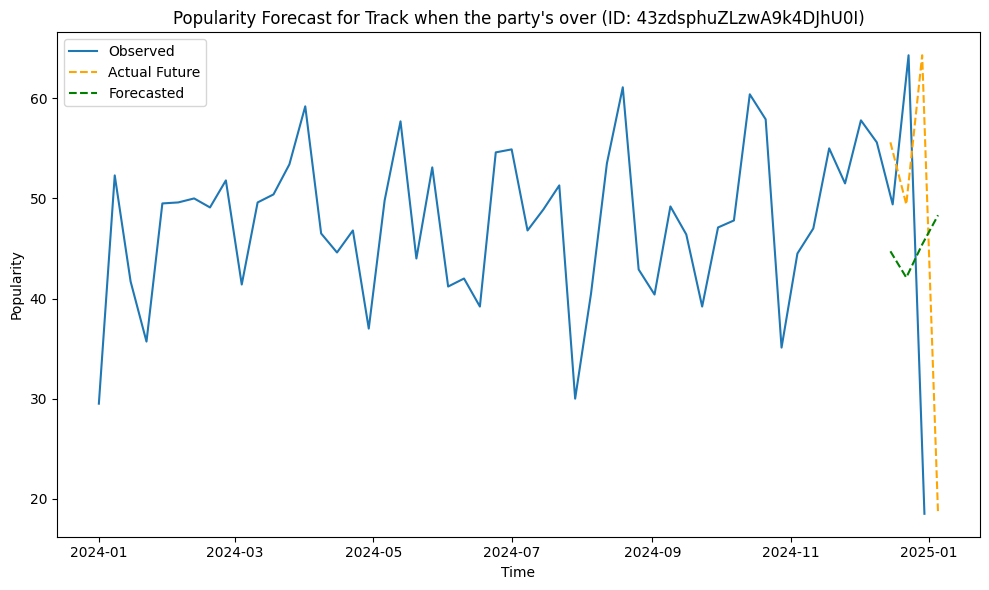

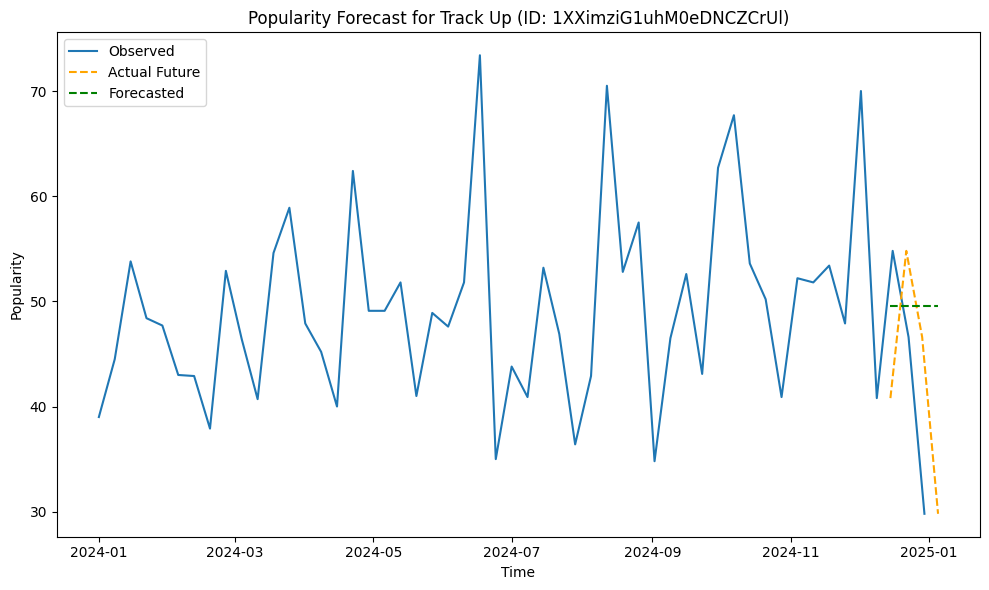

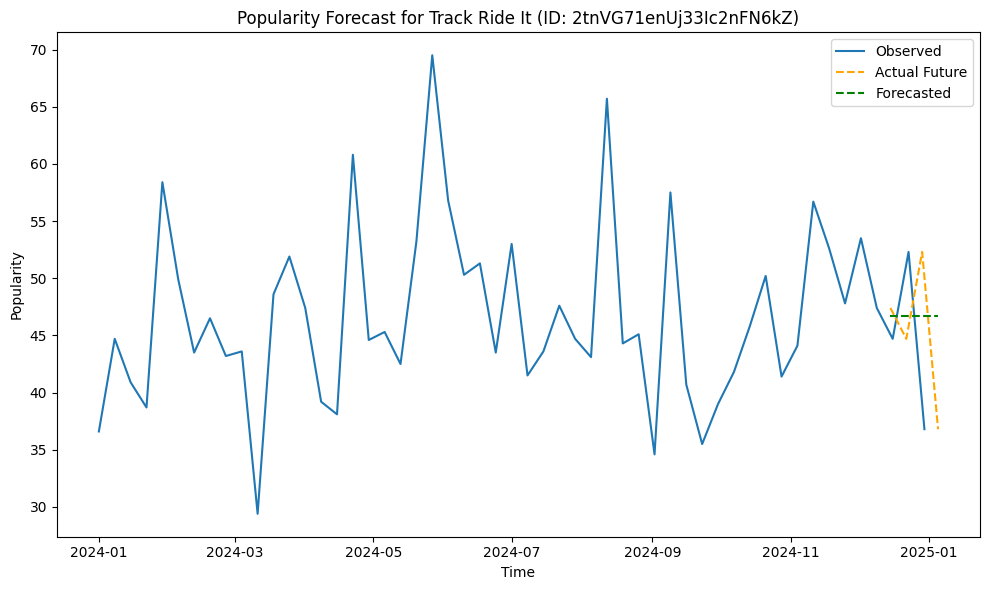

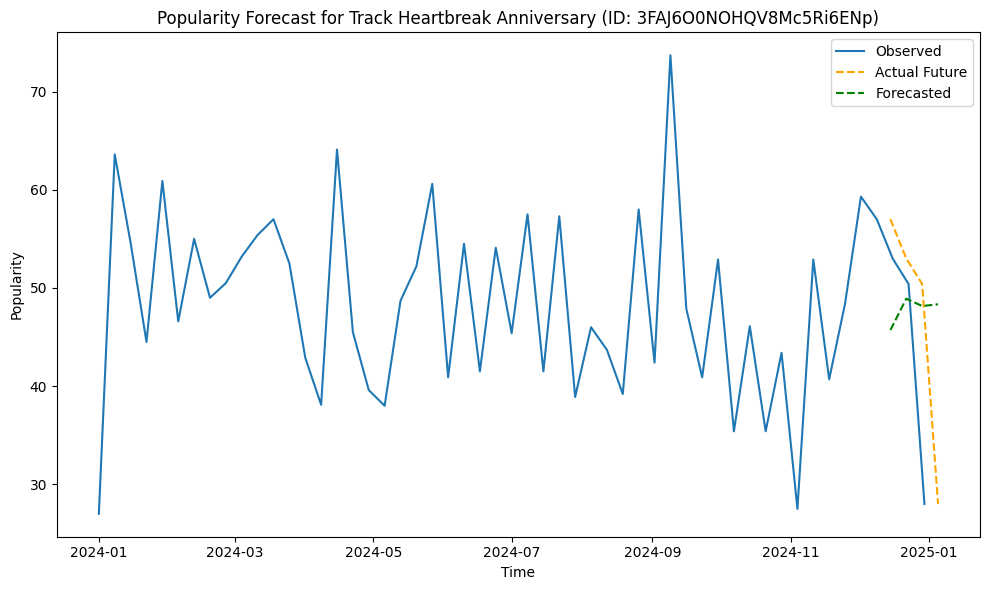

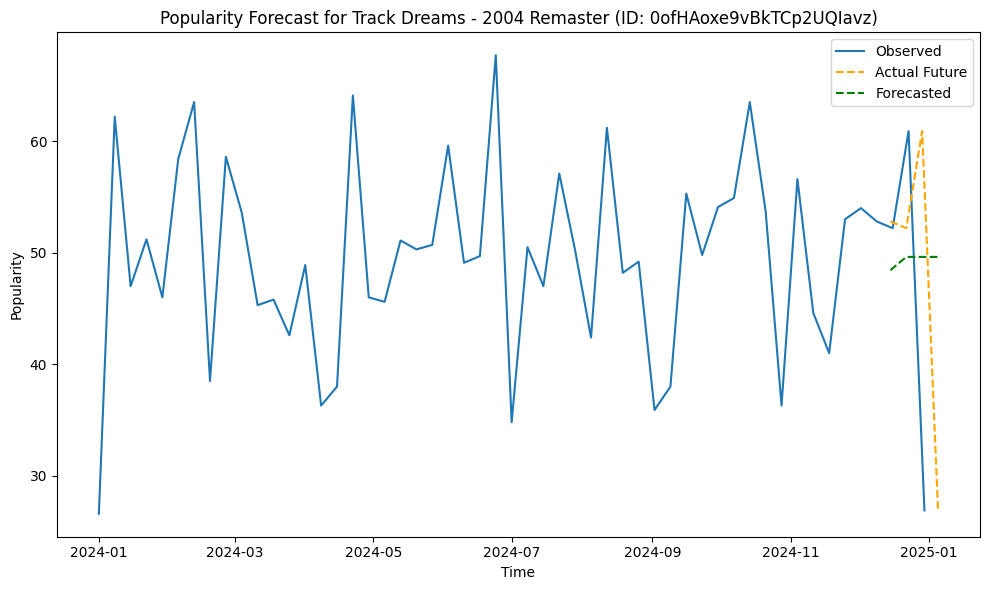

In [14]:
print("Wizualizacja wyników dla pierwszych utworów...")
for result in results[:5]:  # Wizualizacja dla 5 pierwszych utworów
    track_name = result['track_name']
    track_id = result['track_id']
    forecast = result['forecast']
    test_data = result['test_data']
    
    # Pobranie danych historycznych
    track_data = weekly_scores[weekly_scores['track_id'] == track_id]
    track_data = track_data.set_index('week')['weekly_popularity_score'].sort_index()
    track_data = track_data.asfreq('W')
    
    track_data.index = track_data.index.to_timestamp()

    # Wizualizacja danych historycznych i prognozy
    plt.figure(figsize=(10, 6))
    plt.plot(track_data.index, track_data, label='Observed')
    plt.plot(test_data.index, test_data, label='Actual Future', linestyle='--', color='orange')
    plt.plot(test_data.index, forecast, label='Forecasted', linestyle='--', color='green')
    plt.title(f"Popularity Forecast for Track {track_name} (ID: {track_id})")
    plt.xlabel("Time")
    plt.ylabel("Popularity")
    plt.legend()
    plt.tight_layout()
    plt.show()

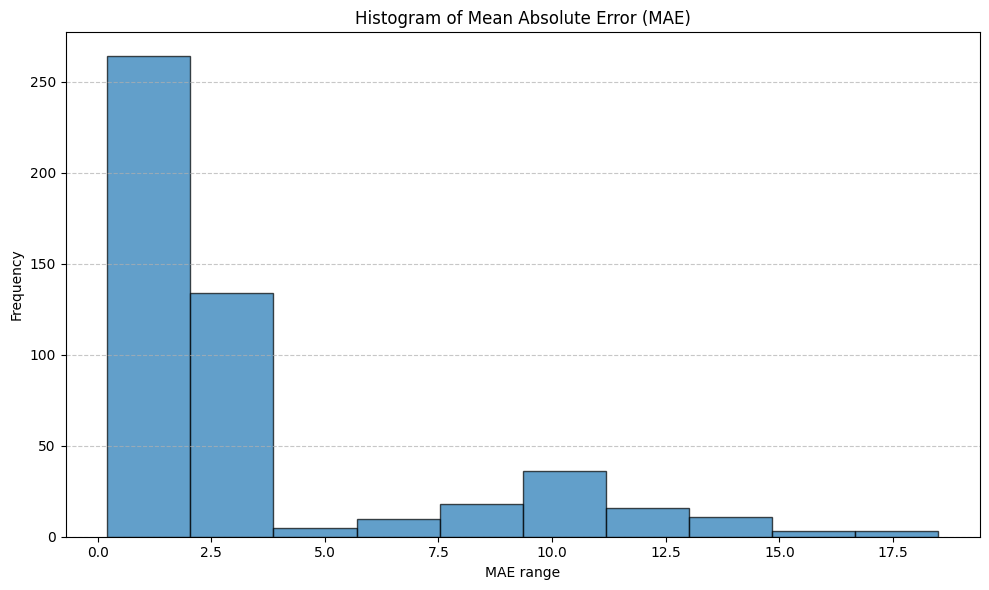

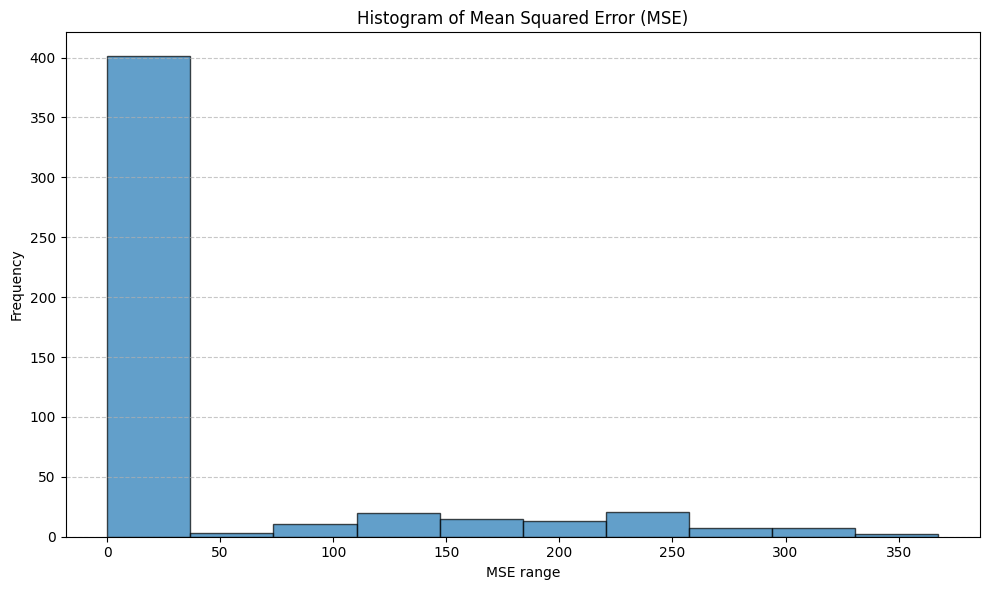

Zakończono przetwarzanie 500 utworów.
Podsumowanie błędów:
              MAE         MSE
count  500.000000  500.000000
mean     3.558642   42.101618
std      3.729820   80.465112
min      0.211905    0.087948
25%      1.450000    2.970603
50%      1.974359    5.760269
75%      3.005625   12.293997
max     18.498469  367.596948


In [13]:
# Zapis błędów do DataFrame
error_df = pd.DataFrame(error_results)

# Histogram błędów MAE
plt.figure(figsize=(10, 6))
plt.hist(error_df['MAE'], bins=10, edgecolor="black", alpha=0.7)
plt.title("Histogram of Mean Absolute Error (MAE)")
plt.xlabel("MAE range")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Histogram błędów MSE
plt.figure(figsize=(10, 6))
plt.hist(error_df['MSE'], bins=10, edgecolor="black", alpha=0.7)
plt.title("Histogram of Mean Squared Error (MSE)")
plt.xlabel("MSE range")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Podsumowanie wyników
print(f"Zakończono przetwarzanie {len(results)} utworów.")
print("Podsumowanie błędów:")
print(error_df.describe())

In [47]:
print(results[0]["forecast"])
forecast_df = pd.DataFrame(results)
print(forecast_df["forecast"][0][0])

one_week_forecast = []
for result in results:
    print("JEDEN")
    print(result['forecast'])
    one_week_forecast.append({
        "track_id": result['track_id'],
        "track_name": result['track_name'],
        "forecast": result['forecast'][3],
    })

one_week_forecast_df = pd.DataFrame(one_week_forecast)
top_50_forecast = one_week_forecast_df.sort_values(by='forecast', ascending=False).head(50)
# top_50_actual = one_week_forecast_df.sort_values(by='test_data', ascending=False).head(50)

predicted_top_50_ids = set(top_50_forecast['track_id'])

predicted_week = results[0]['forecast'].index[3]
print(predicted_week)
print(weekly_scores['week'].unique()[-4])
forth_end_week_track_popularity = weekly_scores.groupby('track_id').apply(avg_popularity_in_week_range, start_week = predicted_week, end_week = predicted_week).reset_index(name='avg_popularity')
top_50_actual = forth_end_week_track_popularity.sort_values(by='avg_popularity', ascending=False).head(50)
top_50_actual = top_50_actual.merge(tracks[['id', 'name']], left_on='track_id', right_on='id', how='left')

actual_top_50_ids = set(top_50_actual['track_id'])

# Liczba przewidzianych utworów faktycznie obecnych na liście rzeczywistych
correct_predictions = predicted_top_50_ids.intersection(actual_top_50_ids)

# Obliczanie statystyk
num_correct_predictions = len(correct_predictions)
total_predictions = len(predicted_top_50_ids)
total_actual = len(actual_top_50_ids)

# Wyświetlanie wyników
print(f"Liczba trafionych utworów: {num_correct_predictions}")
print(f"Liczba utworów na liście prognozowanych: {total_predictions}")
print(f"Liczba utworów na rzeczywistej liście: {total_actual}")
print(f"Procent trafień: {num_correct_predictions / total_predictions * 100:.2f}%")

2024-12-09/2024-12-15    44.719757
2024-12-16/2024-12-22    42.099699
2024-12-23/2024-12-29    45.397000
2024-12-30/2025-01-05    48.320741
Freq: W-SUN, dtype: float64
44.719756887220896
JEDEN
2024-12-09/2024-12-15    44.719757
2024-12-16/2024-12-22    42.099699
2024-12-23/2024-12-29    45.397000
2024-12-30/2025-01-05    48.320741
Freq: W-SUN, dtype: float64
JEDEN
2024-12-09/2024-12-15    49.514286
2024-12-16/2024-12-22    49.514286
2024-12-23/2024-12-29    49.514286
2024-12-30/2025-01-05    49.514286
Freq: W-SUN, dtype: float64
JEDEN
2024-12-09/2024-12-15    46.697959
2024-12-16/2024-12-22    46.697959
2024-12-23/2024-12-29    46.697959
2024-12-30/2025-01-05    46.697959
Freq: W-SUN, dtype: float64
JEDEN
2024-12-09/2024-12-15    45.711169
2024-12-16/2024-12-22    48.914838
2024-12-23/2024-12-29    48.159549
2024-12-30/2025-01-05    48.337614
Freq: W-SUN, dtype: float64
JEDEN
2024-12-09/2024-12-15    48.435194
2024-12-16/2024-12-22    49.625781
2024-12-23/2024-12-29    49.625781
2024-1

/tmp/ipykernel_39430/2084478784.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(forecast_df["forecast"][0][0])
/tmp/ipykernel_39430/2084478784.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "forecast": result['forecast'][2],


Liczba trafionych utworów: 23
Liczba utworów na liście prognozowanych: 50
Liczba utworów na rzeczywistej liście: 50
Procent trafień: 46.00%


/tmp/ipykernel_39430/2084478784.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forth_end_week_track_popularity = weekly_scores.groupby('track_id').apply(avg_popularity_in_week_range, start_week = predicted_week, end_week = predicted_week).reset_index(name='avg_popularity')


In [ ]:
top_tracks_global = tracks_with_counts.sort_values(by='popularity_score', ascending=False).head(50)
